# Simulating Bell Inequality using Momentum Mixing

## Setup

In [1]:
!python -V

Python 3.10.8


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
import scipy
from matplotlib import gridspec
import matplotlib
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#
# from tqdm import tqdm

import pickle
import pgzip
import os

from joblib import Parallel, delayed
N_JOBS=7
from tqdm.notebook import tqdm
# from tqdm import tqdm
from datetime import datetime

import pyfftw
nthreads=2

%config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'pdf'
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [3]:
# from numba import njit, prange, set_parallel_chunksize, get_parallel_chunksize,parallel_chunksize

In [4]:
use_cache = True
save_cache = False
output_prefix = "output/bell_simu_proj/("+\
                datetime.now().strftime("%Y%m%d-%H%M%S") + "-" + \
                str("T" if use_cache else "F") + \
                str("T" if save_cache else "F") + \
                ") "
output_ext = ".pgz.pkl"
print(output_prefix)

output/bell_simu_proj/(20230131-201615-TF) 


In [5]:
import platform
if save_cache:
    with open(output_prefix + "session_info.txt", "wt") as file:
        string = ""
        string += ("="*20 + "Session System Information" + "="*20) + "\n"
        uname = platform.uname()
        string +=  f"Python Version: {platform.python_version()}\n"
        string +=  f"Platform: {platform.platform()}\n"
        string += (f"System: {uname.system}")+ "\n"
        string += (f"Node Name: {uname.node}")+ "\n"
        string += (f"Release: {uname.release}")+ "\n"
        string += (f"Version: {uname.version}")+ "\n"
        string += (f"Machine: {uname.machine}")+ "\n"
        string += (f"Processor: {uname.processor}")+ "\n"
        string +=  f"CPU Counts: {os.cpu_count()} \n"
    #     print(string)
        file.write(string)

## Simulation parameters

In [6]:
nx = 2000+1
nz = 2000+1
xmax = 60 #Micrometers
zmax = (nz/nx)*xmax
dt = 1e-4 # Milliseconds
dx = 2*xmax/(nx-1)
dz = 2*zmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

print("zmax =", zmax)
print("(dx,dz) =", (dx, dz) ) 
print("rotate phase =", 1j*hb*dt/(2*m4*dx*dz)) #want this to be small

pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb
print("pxmax =", pxmax)
print("pzmax =", pxmax)

print(round(nx*nz/1000/1000,3),"million grid points")
print(round((nx*nz)*0.001*0.001/60, 2),"minutes/grid_op (for 1μs/element_op)")

zmax = 60.0
(dx,dz) = (0.06, 0.06)
rotate phase = 0.22051319444444445j
pxmax = 3328.585892726259
pzmax = 3328.585892726259
4.004 million grid points
0.07 minutes/grid_op (for 1μs/element_op)


In [7]:
wavelength = 1.083 #Micrometers
k = (1/sqrt(2)) * 2*pi / wavelength # effective wavelength
# k = 2*pi / wavelength
dopd = 60.1025 # 1/ms Doppler detuning (?)
p = 2*hb*k
print("k  =",k,"1/µm")
print("p  =",p, "u*µm/ms")
v4 = hb*k/m4
print("v4 =",v4, "µm/ms")

# sanity check
assert (pxmax > p*2.5 or pzmax > p*2.5), "momentum resolution too small"

k  = 4.102384984449092 1/µm
p  = 521.0668902307921 u*µm/ms
v4 = 65.13336127884901 µm/ms


In [8]:
a4 = 0.007512 # scattering length 
omega = 50 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggPi = np.sqrt(2*pi*hb)/V0
# tBraggCenter = 1
tBraggCenter = tBraggPi * 5
tBraggEnd = tBraggPi * 10
print("V0 =", V0)
# print(round(tBraggPi,6) ,"ms")
print("tBraggPi     =", round(tBraggPi*1000,3),"µs")
print("tBraggCenter =", round(tBraggCenter*1000,3),"µs")
print("tBraggEnd    =", round(tBraggEnd*1000,3),"µs")

def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)

def VB(t, tauMid, tauPi):
        return V0 * (2*pi)**-0.5 * tauPi**-1 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)

V0F = 50*1000
def VBF(t, tauMid, tauPi, V0FArg=V0F):
        return V0FArg * (2*pi)**-0.5 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)

V0 = 6350.780000000001
tBraggPi     = 3.145 µs
tBraggCenter = 15.727 µs
tBraggEnd    = 31.454 µs


In [9]:
print(1j*(dt/hb), "term infront of Bragg potential")
print(1j*(dt/hb)*V(tBraggCenter), "max(V)")

1.5746097329776815e-06j term infront of Bragg potential
1.2683340910935947j max(V)


In [10]:
xlin = np.linspace(-xmax,+xmax, nx)
zlin = np.linspace(-zmax,+zmax, nz)
psi=np.zeros((nx,nz),dtype=complex)
print(round(psi.nbytes/1000/1000 ,3) , "MB of data used")
# print(psi.nbytes/1000/1000, "MB of data used")

zones = np.ones(nz)
xgrid = np.tensordot(xlin,zones,axes=0)
cosGrid = np.cos(2*k*xgrid)

64.064 MB of data used


##### Checking parameters reasonable

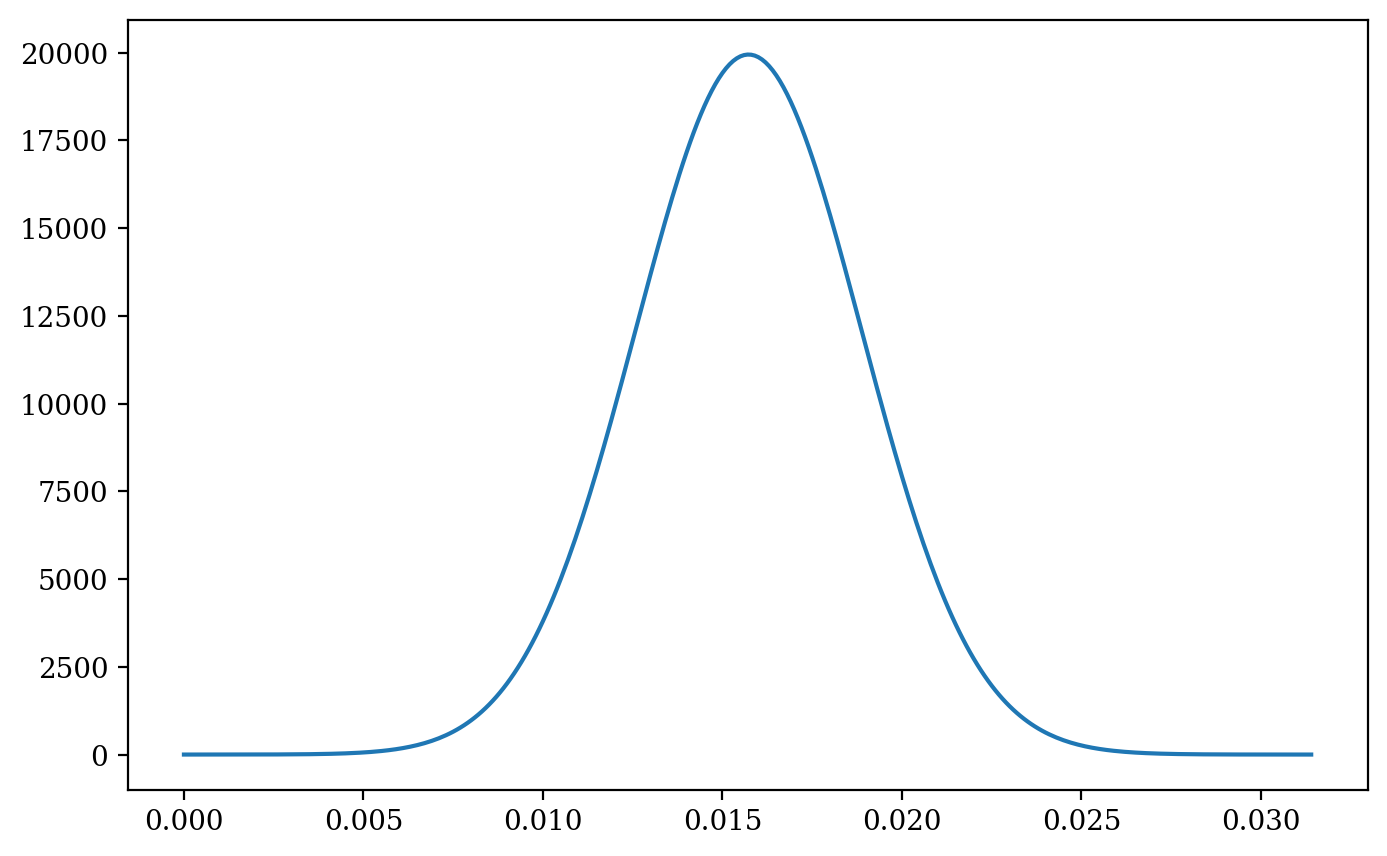

In [11]:
# smooth bragg in time
tbtest = np.arange(tBraggCenter-5*tBraggPi,tBraggCenter+5*tBraggPi,dt)
# plt.plot(tbtest, V(tbtest))
plt.plot(tbtest, VBF(tbtest,tBraggPi*5,tBraggPi))

In [12]:
np.trapz(V(tbtest),tbtest) # this should be V0

6350.776181415861

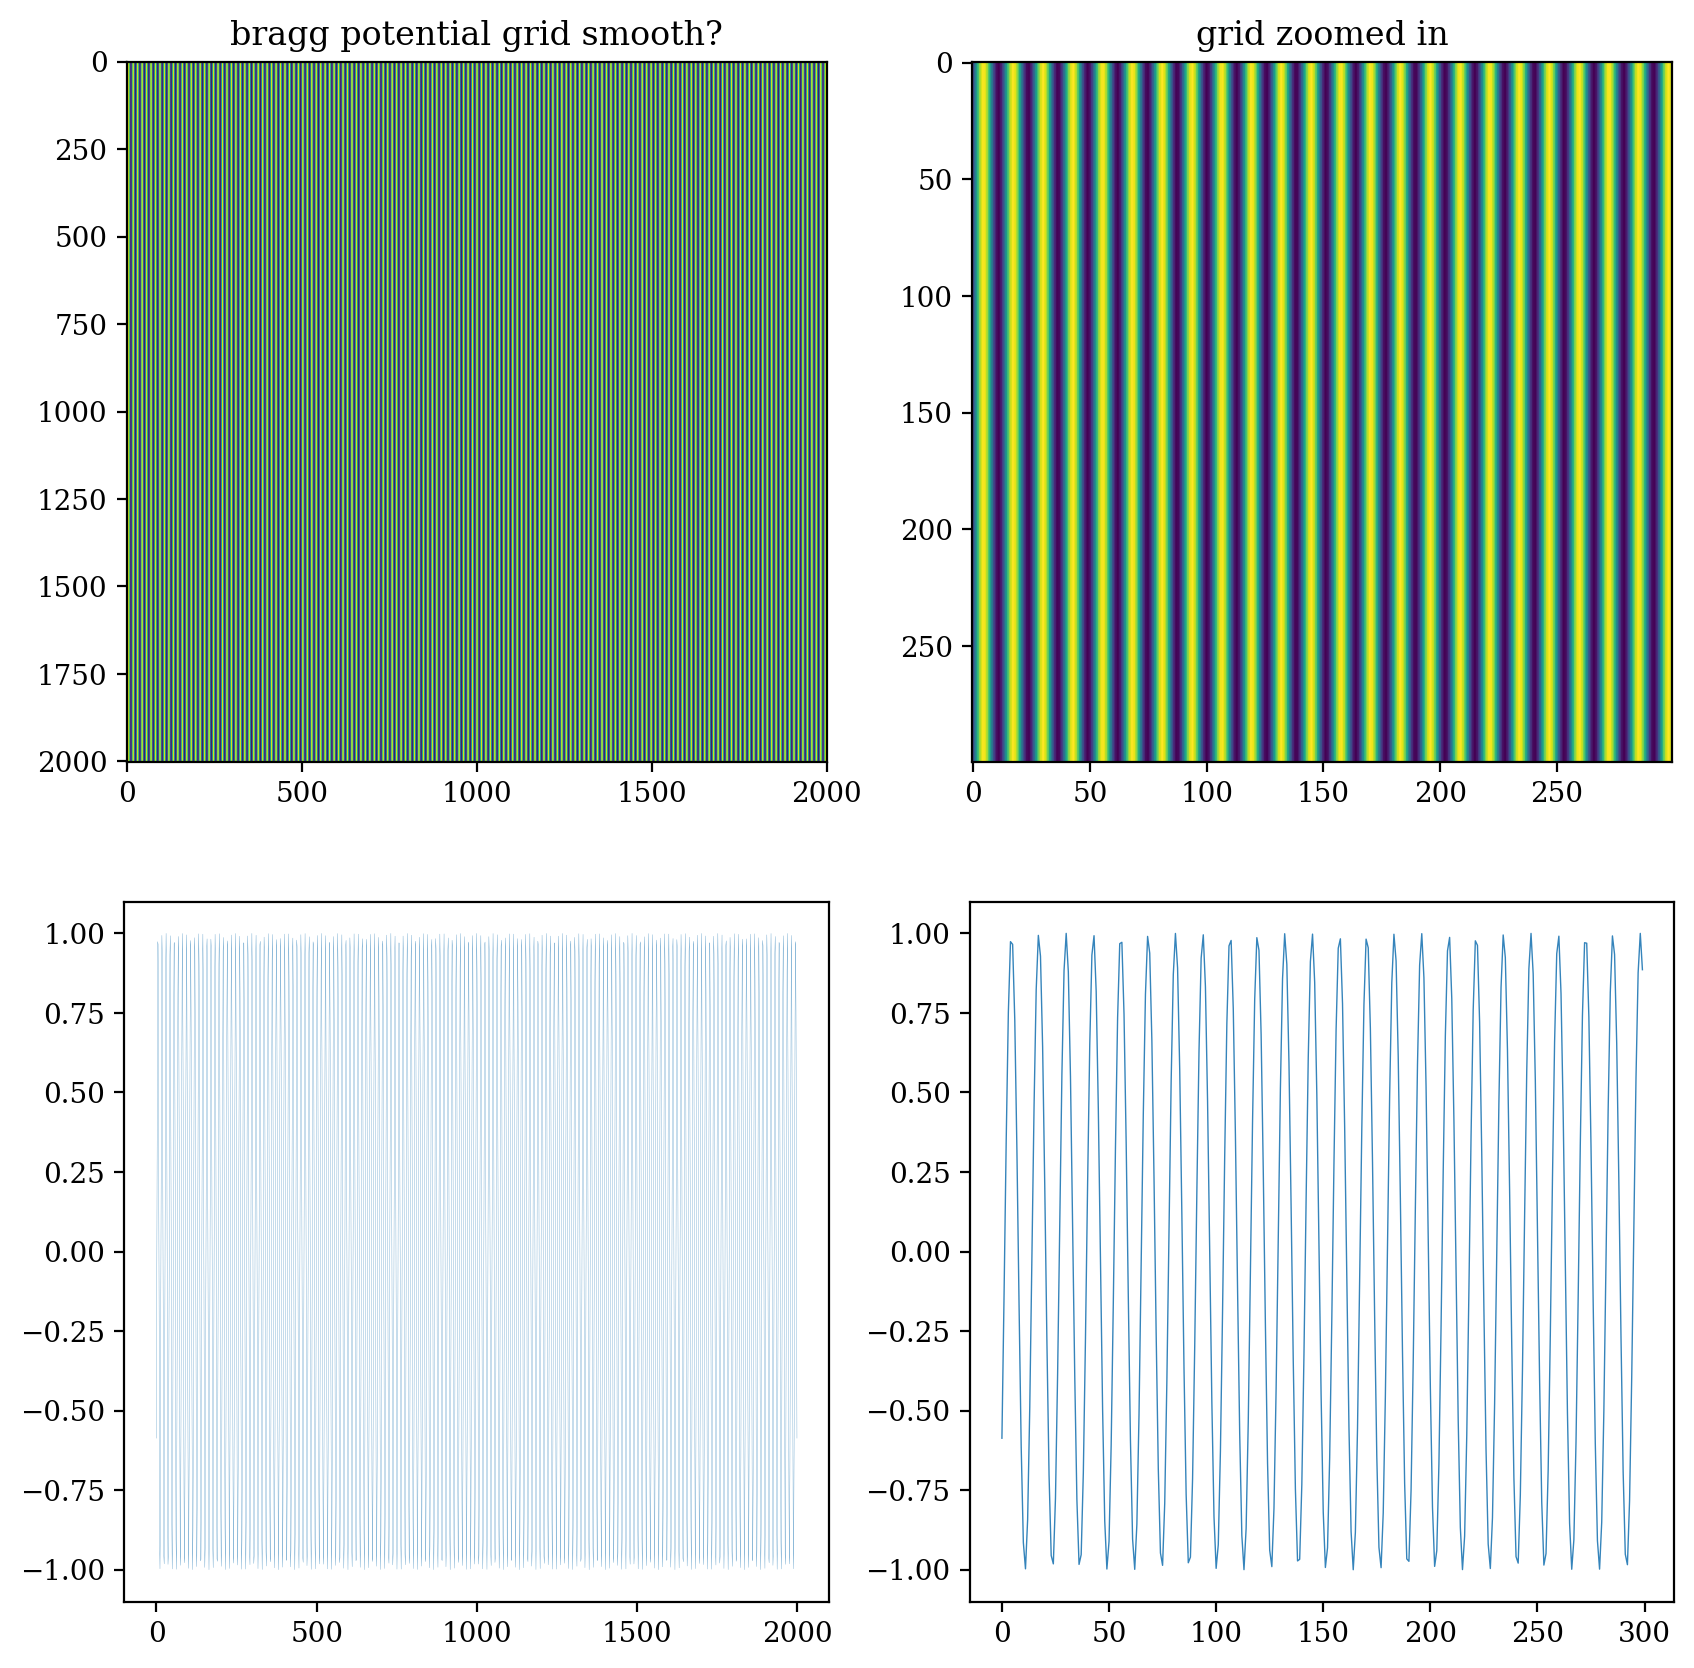

In [13]:
# vtest = np.cos(2*k*xlin)
ncrop = 300
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(cosGrid.T)
plt.title("bragg potential grid smooth?")

plt.subplot(2,2,2)
plt.imshow(cosGrid[:ncrop,:ncrop].T)
plt.title("grid zoomed in")

plt.subplot(2,2,3)
plt.plot(cosGrid[:,0],alpha=0.9,linewidth=0.1)

plt.subplot(2,2,4)
plt.plot(cosGrid[:ncrop,0],alpha=0.9,linewidth=0.5)

title="bragg_potential_grid"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)

plt.show()

#### More backend stuff

In [14]:
def plot_psi(psi, plt_show=True):
    """Plots $\psi$ of position wavefunction

    Args:
        psi (ndarray 2d): wavefunction dtype=complex
    """    
    
    plt.figure(figsize=(12, 4))
    extent = np.array([-xmax, +xmax, -zmax, +zmax])
    plt.subplot(1, 3, 1)
    plt.imshow(np.abs(psi.T)**2, extent=extent)
    plt.ylabel("$z$ (µm)")
    plt.xlabel("$x$ (µm)")
    plt.title("Position $|\psi|^2$")
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.real(psi.T), extent=extent)
    plt.xlabel("$x$ (µm)")
    plt.title("$\mathrm{Re}(\psi)$")
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.imag(psi.T), extent=extent)
    plt.xlabel("$x$ (µm)")
    plt.title("$\mathrm{Im}(\psi)$")
    
    if plt_show: plt.show()


In [15]:
def plot_mom(psi, zoom_div2=15, zoom_div3=6, plt_show=True):
    """Plots momentum wavefunction

    Args:
        psi (ndarray 2d): complex position wavefunction
    """    
    
    
    plt.figure(figsize=(12,3))
    pspace = np.fft.fftfreq(nx)
    extent = np.array([-pxmax,+pxmax,-pzmax,+pzmax])/(hb*k)
#     psifft = np.fft.fftshift(np.fft.fft2(psi))
    psifft = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))
    psiAbsSqUnNorm = np.abs(psifft)**2
    swnf = sqrt(np.sum(psiAbsSqUnNorm)*dpx*dpz)
    psiAbsSq = psiAbsSqUnNorm / swnf
#     print(np.sum(psiAbsSq)*dpx*dpz)
#     plotdata = np.flipud(psiAbsSq.T)
    plotdata = (psiAbsSq.T)
    
    plt.subplot(1,3,1)
    plt.imshow(plotdata,extent=extent) 
    plt.ylabel("$p_z \ (\hbar k)$")
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.title("Momentum $|\phi|^2$")
    
    plt.subplot(1,3,2)
    nxm = int((nx-1)/2)
    nzm = int((nz-1)/2)
    nx2 = int((nx-1)/zoom_div2)
    nz2 = int((nz-1)/zoom_div2)
    plotdata = (psiAbsSq[nxm-nx2:nxm+nx2,nzm-nz2:nzm+nz2].T)
    plt.imshow(plotdata,
               extent=np.array([pxlin[nxm-nx2],pxlin[nxm+nx2],pzlin[nzm-nz2],pzlin[nzm+nz2]])/(hb*k)) 
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.title("zoomed in")
    
    
    plt.subplot(1,3,3)
#     nx3 = int((nx-1)/200)
#     nz3 = int((nz-1)/200)
#     plotdata = np.flipud(psiAbsSq[nxm-nx3:nxm+nx3,nzm-nz3:nzm+nz3].T)
#     plt.imshow(plotdata,extent=extent*0.01) 
# #     print(nx2,nz2,nx3,nz3)
#     nxm = int((nx-1)/2)
#     nzm = int((nz-1)/2)
    nx2 = int((nx-1)/zoom_div3)
#     nz2 = int((nz-1)/zoom_div3)
    
    plt.plot((pxlin[nxm-nx2:nxm+nx2])/(hb*k), np.trapz(psiAbsSq,axis=1)[nxm-nx2:nxm+nx2])
    plt.axvline(x= 0,color='r',alpha=0.2)
    plt.axvline(x=+2,color='r',alpha=0.2)
    plt.axvline(x=-2,color='r',alpha=0.2)
#     plt.axvline(x=+4,color='r',alpha=0.2)
#     plt.axvline(x=-4,color='r',alpha=0.2)
#     plt.xlabel("$p (u\cdot \mu m/ms)$")
#     plt.ylabel("$|\phi(p)|^2$")
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.title("integrated over $p_z$")
    
#     plt.savefig("output/"+title+".pdf", dpi = 300) 
#     plt.savefig("output/"+title+".png", dpi = 300) 
#     plt.show()
    
    if plt_show: plt.show()

In [16]:
sg=0.2

def psi0(x,z,sx=sg,sz=sg,px=0,pz=0):
    return (1/np.sqrt(pi*sx*sz)) \
            * np.exp(-0.5*x**2/sx**2) \
            * np.exp(-0.5*z**2/sz**2) \
            * np.exp(+(1j/hb)*(px*x + pz*z))
def psi0ringUnNorm(x,z,pr=p,mur=10,sg=sg):
#     return (pi**1.5 * sg * (1 + scipy.special.erf(mur/sg)))**-1 \
    return 1 \
            * np.exp(-0.5*( mur - np.sqrt(x**2 + z**2) )**2 / sg**2) \
            * np.exp(+(1j/hb) * (x**2 + z**2)**0.5 * pr)

In [17]:
# V00 = 50000
# dt=0.01
# VxExpGrid = np.exp(-(1j/hb) * 0.5*dt * V00 * cosGrid )
dpx = 2*pi/(2*xmax)*hb
dpz = 2*pi/(2*zmax)*hb
pxlin = np.linspace(-pxmax,+pxmax,nx)
pzlin = np.linspace(-pzmax,+pzmax,nz)

expPGrid = np.zeros((nx,nz),dtype=complex)
for indx in range(nx):
    expPGrid[indx, :] = np.exp(-(1j/hb) * (0.5/m4) * (dt) * (pxlin[indx]**2 + pzlin**2)) 
        

In [18]:
def psi0np(mux=10,muz=10,p0x=0,p0z=0):
    psi=np.zeros((nx,nz),dtype=complex)
    for ix in range(1,nx-1):
        x = xlin[ix]
        psi[ix][1:-1] = psi0(x,zlin[1:-1],mux,muz,p0x,p0z)
    return psi
def psi0ringNp(mur=1,sg=1,pr=p):
    psi = np.zeros((nx,nz),dtype=complex)
    for ix in range(1,nx-1):
        x = xlin[ix]
        psi[ix][1:-1] = psi0ringUnNorm(x,zlin[1:-1],pr,mur,sg)
    norm = np.sum(np.abs(psi)**2)*dx*dz
    psi *= 1/sqrt(norm)
    return psi

Super weird normalisation factor, swnf = 55.42101053490277
0.9999999999999998 |phi|**2 normalisation check
1.0000000000000009 |psi|**2 normalisation check


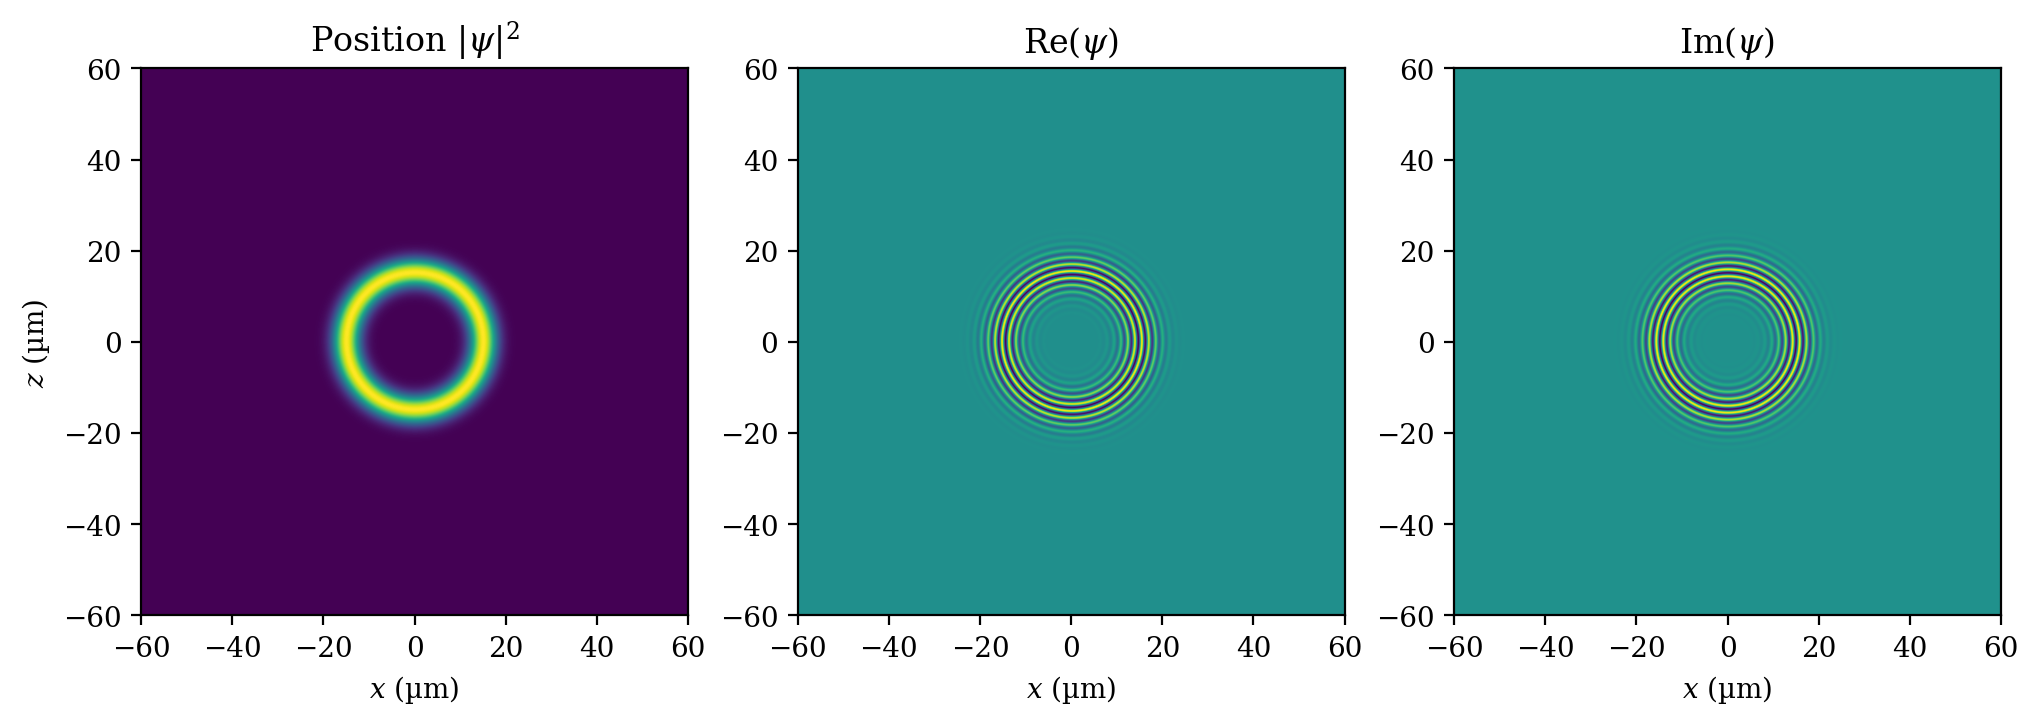

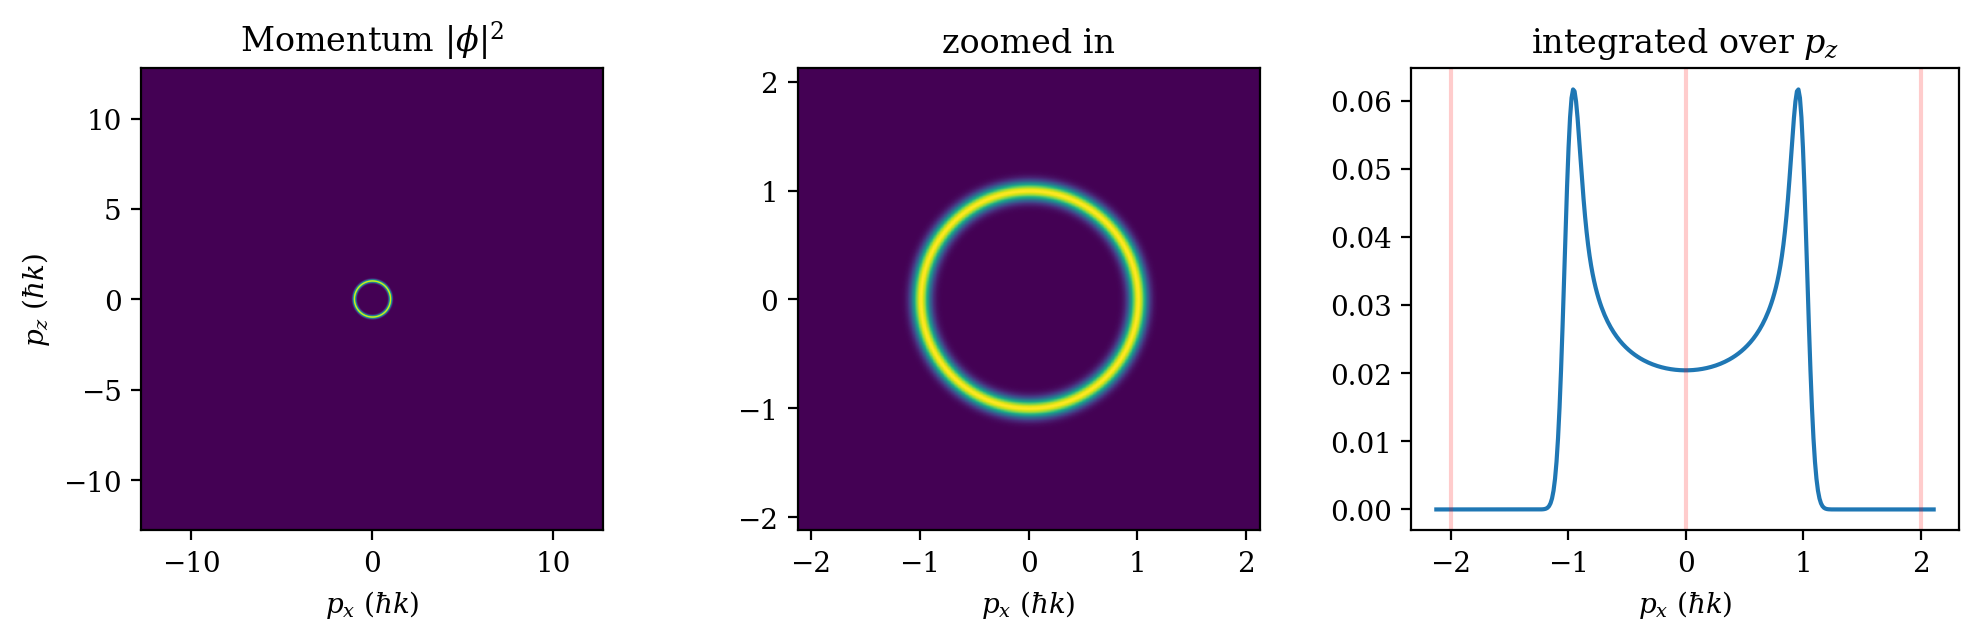

In [19]:
# psi = psi0np(5,5,0,0)
# psi = psi0np(5,5,-0.5*p,0)
# psi = psi0np(1,1,p,p)
# psi = psi0np(1,1,0,0)

def phiAndSWNF(psi):
    phiUN = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))
    # superWeirdNormalisationFactorSq = np.trapz(np.trapz(np.abs(phiUN)**2, pxlin, axis=0), pzlin)
    superWeirdNormalisationFactorSq = np.sum(np.abs(phiUN)**2)*dpx*dpz
    swnf = sqrt(superWeirdNormalisationFactorSq)
    phi = phiUN/swnf
    return (swnf, phi)
    
psi = psi0ringNp(15,3,0.5*p)
(swnf, phi) = phiAndSWNF(psi)

t = 0

print("Super weird normalisation factor, swnf =",swnf)
print(np.sum(np.abs(phi)**2)*dpx*dpz, "|phi|**2 normalisation check")
print(np.sum(np.abs(psi)**2)*dx*dz,   "|psi|**2 normalisation check")
plot_psi(psi,False)
title="init_ring_psi"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

plot_mom(psi,12,12,False)
title="init_ring_phi"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()


In [20]:
def toMomentum(psi, swnf):
    return np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))/swnf
def toPosition(phi, swnf):
    return pyfftw.interfaces.numpy_fft.ifft2(np.fft.ifftshift(np.fliplr(phi*swnf)),threads=nthreads,norm='ortho')


In [21]:
def plotNow(t, psi):
        print("time =", round(t*1000,4), "µs")
        print(np.sum(np.abs(psi)**2)*dx*dz,"|psi|^2")
        print(np.sum(np.abs(phi)**2)*dpx*dpz,"|phi|^2")
        plot_psi(psi)
        plot_mom(psi)

def numericalEvolve(
        t_init, 
        psi_init, 
        t_final, 
        tauPi  = tBraggPi, 
        tauMid = tBraggPi*5, 
        phase  = 0,
        doppd=dopd,
        print_every_t=-1, 
        final_plot=True,
        progress_bar=True, 
    ):
    assert (print_every_t > dt or print_every_t <= 0), "print_every_t cannot be smaller than dt"
    steps = ceil((t_final - t_init) / dt) 
    t = t_init
    psi = psi_init.copy()
    (swnf, phi) = phiAndSWNF(psi)
    
#     tauMid = tauPi * 5
#     tauEnd = tauPi * 10

    def loop():
        nonlocal t
        nonlocal psi
        nonlocal phi
        cosGrid = np.cos(2*k*xgrid + doppd*(t-tBraggCenter) + phase)
        VxExpGrid = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tauMid,tauPi) * cosGrid )
        psi *= VxExpGrid
        phi = toMomentum(psi,swnf)
        phi *= expPGrid
        psi = toPosition(phi,swnf)
        psi *= VxExpGrid
        
        if print_every_t > 0 and step % round(print_every_t / dt) == 0: 
            plotNow(t,psi)
        t += dt 
        
    if progress_bar:
        for step in tqdm(range(steps)):
            loop()
    else:
        for step in range(steps):
            loop()
    
    if final_plot:
        print("ALL DONE")
        plotNow(t,psi)
    return (t,psi,phi)

In [22]:
_ = numericalEvolve(0, psi0np(1,1,0,0), dt, final_plot=False, progress_bar=False)

In [23]:
def freeEvolve(
    t_init,
    psi,
    t_final,
    final_plot=True,
    logging=False,
    ):
    Dt = t_final-t_init
    
    (swnf, phi) = phiAndSWNF(psi)
    
    if logging: print("checking this value is small ", -(1j/hb) * (0.5/m4) * (Dt)*pxmax)
    expPGridLong = np.zeros((nx,nz),dtype=complex)
    for indx in range(nx):
        expPGridLong[indx, :] = np.exp(-(1j/hb) * (0.5/m4) * (Dt) * (pxlin[indx]**2 + pzlin**2)) 
    
    phi *= expPGridLong
    psi = toPosition(phi,swnf)
    
    if final_plot:
        plotNow(t_final,psi)
        
    return (t_final, psi, phi)

In [24]:
_ = freeEvolve(0,psi0np(1,1,0,0),0.1,final_plot=False,logging=True)

checking this value is small  -0.6551529679673714j


## Bragg Pulse Characterisation

In [25]:
(tBraggCenter,tBraggEnd,tBraggPi)

(0.01572701874067948, 0.03145403748135896, 0.0031454037481358954)

In [26]:
# short test run
_ = numericalEvolve(0, psi0np(5,5,0.5*p,0), 2*dt,progress_bar=False,final_plot=False)

In [27]:
if use_cache: # variable = pickle.load(file)
    with pgzip.open('output/bell_simu_proj/(20230129-220233-FT) tPiTest.pgz.pkl', 'rb', thread=8) as file:
        tPiTest = pickle.load(file)
#     with pgzip.open('output/bell_simu_proj/(20230129-220233-FT) tPiOutput.pgz.pkl', 'rb', thread=8) as file:
#         tPiOutput = pickle.load(file)
else: # compute
    
    tPiTest = np.append(np.arange(0.015,0,-dt), 0) # note this is decending
    # tPiTest = np.arange(dt,3*dt,dt)
    
    tPiOutput = Parallel(n_jobs=N_JOBS)(
        delayed(lambda i: (i, scanTauPiInnerEval(i, False, False)[:2]) )(i) 
        for i in tqdm(tPiTest)
    )       
    
    if save_cache: # pickle.dump(variable, file)
        with pgzip.open(output_prefix+'tPiTest'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(tPiTest, file)  
        with pgzip.open(output_prefix+'tPiOutput'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(tPiOutput, file) 

In [28]:
def scanTauPiInnerEval(tPi, logging=True, progress_bar=True, ang=0, pmom=p, doppd=dopd):
    tauPi  = tPi
    tauMid = tauPi * 5
    tauEnd = tauPi * 10
    if logging:
        print("Testing parameters")
        print("tauPi =", round(tPi,6), "    \t tauMid =", round(tauMid,6), " \t tauEnd = ", round(tauEnd,6))
    output = numericalEvolve(0, psi0np(5,5,0.5*pmom*np.cos(ang),0.5*pmom*np.sin(ang)), 
                             tauEnd, tauPi, tauMid, doppd=doppd,
                             final_plot=logging,progress_bar=progress_bar)
#     if pbar != None: pbar.update(1)
    return output

In [29]:
# _ = scanTauPiInnerEval(dt,False,True)

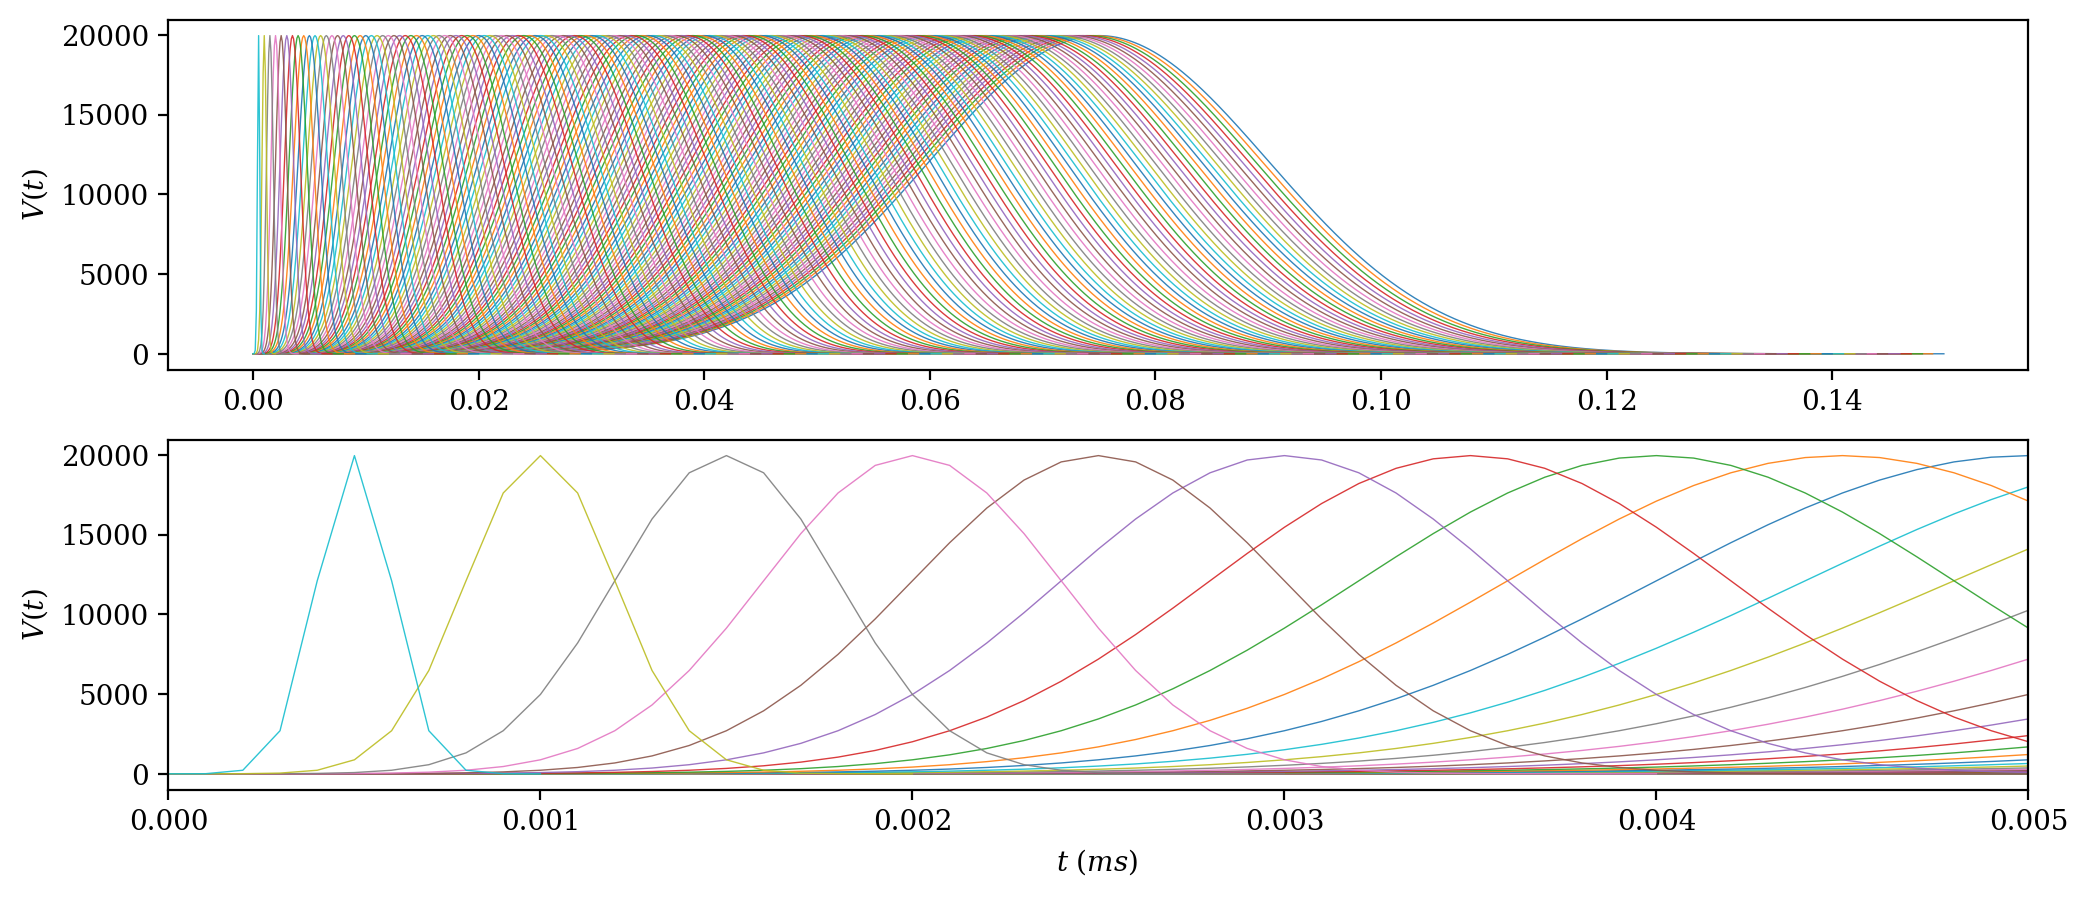

In [30]:
plt.figure(figsize=(12,5))
def plot_inner_helper():
    for (i, tauPi) in enumerate(tPiTest):
        if tauPi == 0: continue
        tauMid = tauPi * 5 
        tauEnd = tauPi * 10 
        tlinspace = np.arange(0,tauEnd,dt)
        plt.plot(tlinspace, VBF(tlinspace, tauMid, tauPi),
                 linewidth=0.5,alpha=0.9
            )
plt.subplot(2,1,1)
plot_inner_helper()
plt.ylabel("$V(t)$")

plt.subplot(2,1,2)
plot_inner_helper()
plt.xlim([0,0.005])
plt.xlabel("$t \ (ms)$ ")
plt.ylabel("$V(t)$")


title="bragg_strength_V0"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)

plt.show()

In [31]:
hbar_k_transfers = np.arange(-6,6+1)
pzlinIndexSet = np.zeros((len(hbar_k_transfers), len(pxlin)), dtype=bool)
cut_p_width = 0.2
for (j, hbar_k) in enumerate(hbar_k_transfers):
    pzlinIndexSet[j] = abs(pxlin/(hb*k) - hbar_k) <= cut_p_width
    # print(i,hbar_k)

In [32]:
if use_cache: # variable = pickle.load(file)
    with pgzip.open('output/bell_simu_proj/(20230130-132508-TF) phiDensityGrid.pgz.pkl', 'rb', thread=8) as file:
        phiDensityGrid = pickle.load(file)
    with pgzip.open('output/bell_simu_proj/(20230130-132508-TF) phiDensityGrid_hbark.pgz.pkl', 'rb', thread=8) as file:
        phiDensityGrid_hbark = pickle.load(file)

else: # compute
    
    phiDensityGrid = np.zeros((len(tPiTest), pxlin.size))
    phiDensityGrid_hbark = np.zeros((len(tPiTest),len(hbar_k_transfers)))

    for i in tqdm(range(len(tPiTest))):
        item = tPiOutput[i]
        (swnf, phi) = phiAndSWNF(item[1][1])
        phiAbsSq = np.abs(phi)**2
        phiX = np.trapz(phiAbsSq, pzlin,axis=1)
        phiDensityGrid[i] = phiX

        for (j, hbar_k) in enumerate(hbar_k_transfers):
            index = pzlinIndexSet[j]
            phiDensityGrid_hbark[i,j] = np.trapz(phiX[index], pxlin[index])
            
    if save_cache: # pickle.dump(variable, file)
        with pgzip.open(output_prefix+'phiDensityGrid'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(phiDensityGrid, file) 
        with pgzip.open(output_prefix+'phiDensityGrid_hbark'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(phiDensityGrid_hbark, file) 


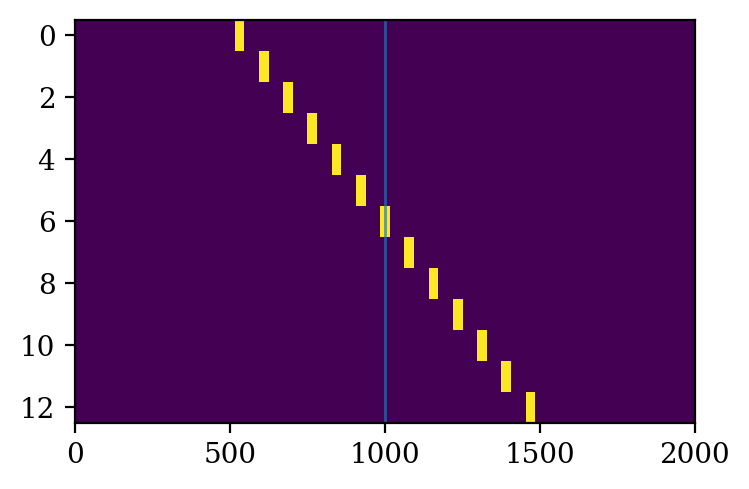

In [33]:
plt.figure(figsize=(4,4))
plt.imshow(pzlinIndexSet,interpolation='none',aspect=100)
plt.axvline(x=1001, linewidth=1, alpha=0.7)

title="hbar_k_pxlin_integration_range"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

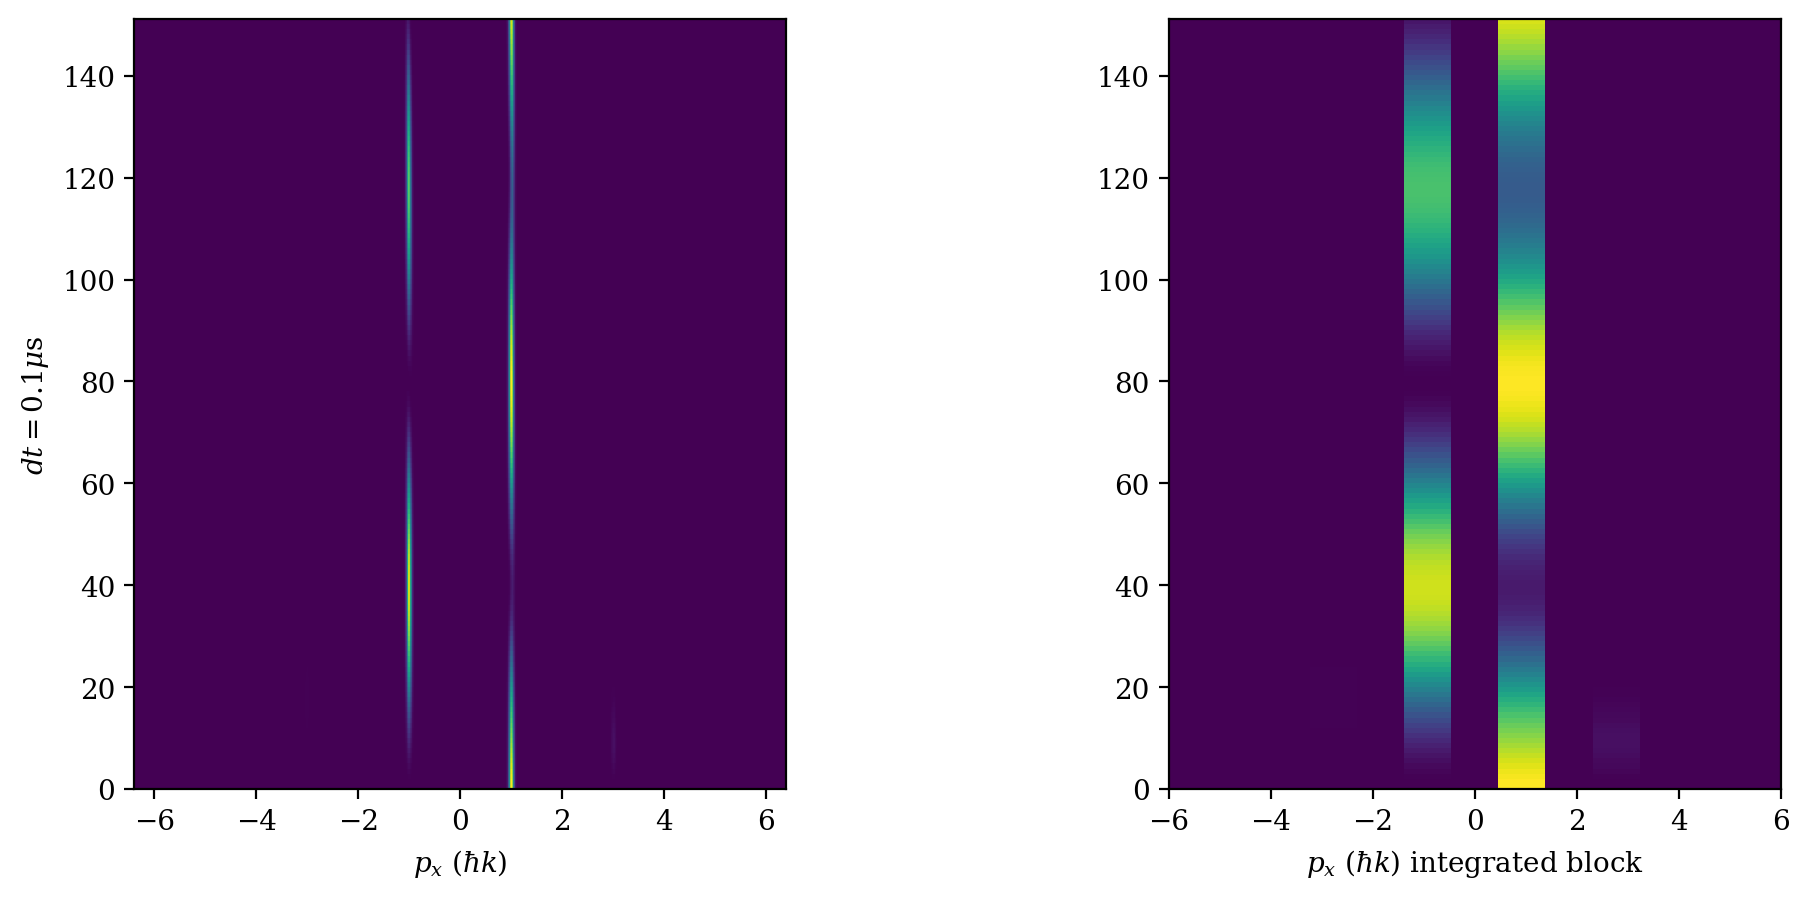

In [34]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

nxm = int((nx-1)/2)
nx2 = int((nx-1)/4)
plt.imshow(phiDensityGrid[:,nxm-nx2:nxm+nx2], 
           extent=[pxlin[nxm-nx2]/(hb*k),pxlin[nxm+nx2]/(hb*k),0,len(tPiTest)], 
           interpolation='none',aspect=0.1)
# plt.imshow(phiDensityGrid, 
#            extent=[-pxmax/(hb*k),pxmax/(hb*k),1,len(tPiTest)+1], 
#            interpolation='none',aspect=1)
# ax = plt.gca()
# for t in tPiTest:
#     plt.axhline(y=t/dt,color='white',alpha=1,linewidth=0.05,linestyle='-')
ax = plt.gca()
ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
plt.ylabel("$dt =$"+str(dt*1000) + "$\mu \mathrm{s}$")
plt.xlabel("$p_x \ (\hbar k)$")


plt.subplot(1,2,2)
plt.imshow(phiDensityGrid_hbark, 
           extent=[hbar_k_transfers[0],hbar_k_transfers[-1],0,len(tPiTest)], 
           interpolation='none',aspect=0.1)
plt.xlabel("$p_x \ (\hbar k)$ integrated block")

title="mom_dist_at_diff_angle"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

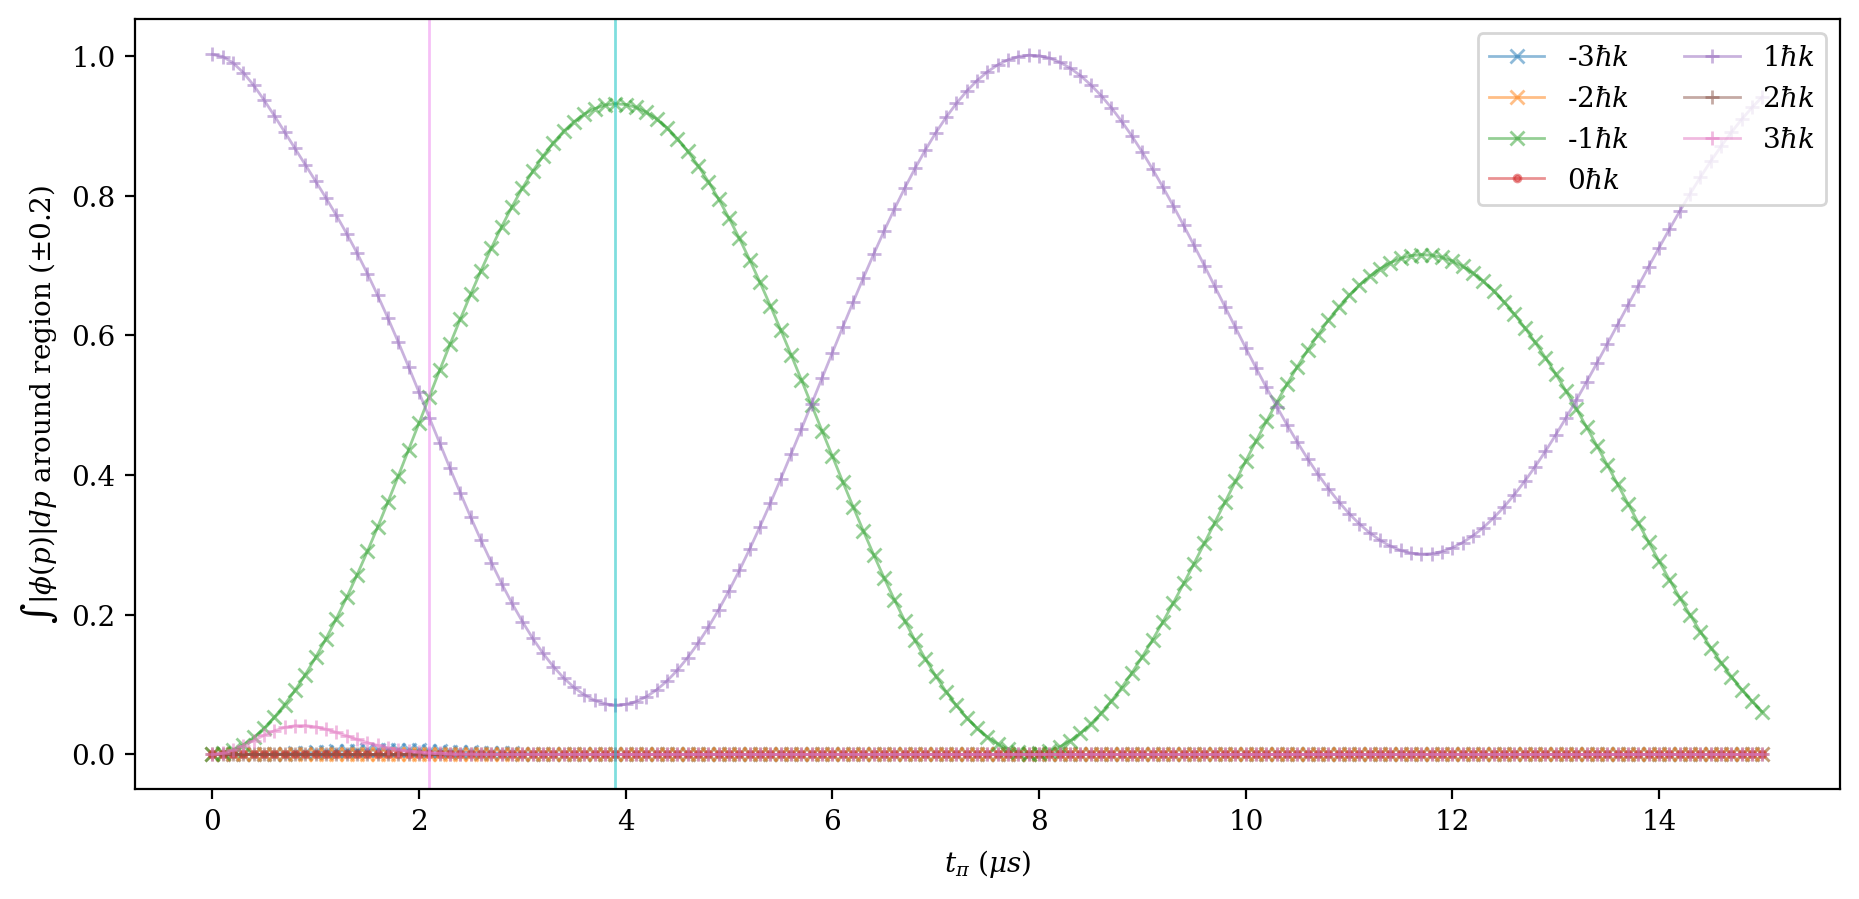

In [35]:
plt.figure(figsize=(11,5))
for (i, hbar_k) in enumerate(hbar_k_transfers):
    if abs(hbar_k) >3: continue
    if   hbar_k > 0: style = '+-'
    elif hbar_k < 0: style = 'x-'
    else:            style = '.-'
    plt.plot(tPiTest*1000, phiDensityGrid_hbark[:,i],
             style, linewidth=1,alpha=0.5, markersize=5,
             label=str(hbar_k)+"$\hbar k$",
            )

plt.legend(loc=1,ncols=2)
plt.ylabel("$\int |\phi(p)| dp$ around region ($\pm$"+str(cut_p_width)+")")
plt.xlabel("$t_\pi \ (\mu s)$")
# plt.axhline(y=np.cos(pi  )**2,color='gray',linewidth=1,alpha=0.5)  # 2*pi pulse
# plt.axhline(y=np.cos(pi/2)**2,color='c',linewidth=1,alpha=0.5)     # pi   pulse
# plt.axhline(y=np.cos(pi/4)**2,color='violet',linewidth=1,alpha=0.5) # pi/2 pulse
# plt.axhline(y=np.cos(pi/8)**2,color='orange',linewidth=1,alpha=0.5)# pi/4 pulse

plt.axvline(x=39*dt*1000,color='c',linewidth=1,alpha=0.5)      # pi   pulse
plt.axvline(x=21*dt*1000,color='violet',linewidth=1,alpha=0.5) # pi/2 pulse
# plt.axvline(x= 9*dt*1000,color='orange',linewidth=1,alpha=0.5)  # pi/4 pulse

# plt.savefig("output/bragg_pulse_duration_test_noline.pdf", dpi=600)
# plt.savefig("output/bragg_pulse_duration_test_noline.png", dpi=600)

plt.show()

## Initial Separation Pulse

### first try

## Halo Sequence

In [ ]:
tauPi  = 39*dt
tauMid = tauPi*5
tauEnd = tauPi*10

tauPi2  = 21*dt
tauMid2 = tauPi2*5
tauEnd2 = tauPi2*10

tauPi4  = 9*dt
tauMid4 = tauPi4*5
tauEnd4 = tauPi4*10

tauEvalList = [[tauPi, tauMid, tauEnd], [tauPi2, tauMid2, tauEnd2], [tauPi4, tauMid4, tauEnd4]]


In [ ]:
if use_cache: # variable = pickle.load(file)
    with pgzip.open('output/bell_simu_proj/(20230129-220233-FT) tauEvalResult.pgz.pkl', 'rb', thread=8) as file:
        tauEvalResult = pickle.load(file)
else: # compute
    tauEvalResult = Parallel(n_jobs=N_JOBS)(delayed(lambda t: 
                                       numericalEvolve(0, psi0ringNp(15,3,0.5*p), t[2] , t[0] , t[1],
                                              final_plot=False, progress_bar=False,)   
                                              )(t)
                                       for t in tauEvalList
                                      )
    # about three minutes
    if save_cache: # pickle.dump(variable, file)
        with pgzip.open(output_prefix+'tauEvalResult'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(tauEvalResult, file) 

In [ ]:
(t_Pi ,psi_Pi ,phi_Pi ) = tauEvalResult[0]
(t_Pi2,psi_Pi2,phi_Pi2) = tauEvalResult[1]
(t_Pi4,psi_Pi4,phi_Pi4) = tauEvalResult[2]

In [ ]:
def plot_mom_xline(phi, cutP=1,plt_show=True,zoom_div=6):
    plt.figure(figsize=(11,4))
    pspace = np.fft.fftfreq(nx)
    psiAbsSqUnNorm = np.abs(phi)**2
    swnf = sqrt(np.sum(psiAbsSqUnNorm)*dpx*dpz)
    psiAbsSq = psiAbsSqUnNorm / swnf
    plotdata = (psiAbsSq.T)
    
    pzlinIndex = abs(pzlin/(hb*k)) <= cutP
    
    plt.subplot(1,2,1)
    nxm = int((nx-1)/2)
    nzm = int((nz-1)/2)
    nx2 = int((nx-1)/zoom_div)
    nz2 = int((nz-1)/zoom_div)
    extent = np.array([pxlin[nxm-nx2],pxlin[nxm+nx2],pzlin[nzm-nz2],pzlin[nzm+nz2]])/(hb*k)
    plotdata = (psiAbsSq[nxm-nx2:nxm+nx2,nzm-nz2:nzm+nz2].T)
    plt.imshow(plotdata,extent=extent) 
    ax = plt.gca()
#     print((extent[0],extent[2]),(extent[1]-extent[0]))
#     ax.add_patch(matplotlib.patches.Rectangle((extent[0],extent[2]),(extent[1]-extent[0]),2))
    ax.add_patch(matplotlib.patches.Rectangle((extent[0],-cutP),(extent[1]-extent[0]),2*cutP,
                                              color='white',alpha=0.15, linewidth=0
                                             ))
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.ylabel("$p_z \ (\hbar k)$")
    plt.title("$|\phi (p)|^2$ Momentum Distribution")
    
    plt.subplot(1,2,2)
    plt.plot((pxlin[nxm-nx2:nxm+nx2])/(hb*k), np.trapz(psiAbsSq[:,pzlinIndex],axis=1)[nxm-nx2:nxm+nx2])
    plt.axvline(x= 0,color='r',alpha=0.2,linewidth=1,linestyle='--')
    plt.axvline(x=+2,color='r',alpha=0.2,linewidth=1,linestyle='--')
    plt.axvline(x=-2,color='r',alpha=0.2,linewidth=1,linestyle='--')
    plt.axvline(x=+4,color='r',alpha=0.2,linewidth=1,linestyle='--')
    plt.axvline(x=-4,color='r',alpha=0.2,linewidth=1,linestyle='--')
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.ylabel("$|\phi(p_x)|^2$")
    plt.title("Integrated $p_z$ over $\pm$"+str(round(cutP,2))+" ($\hbar k$)")
    title = "Bragg Pulse"
    
#     plt.savefig("output/"+title+".pdf", dpi = 300) 
#     plt.savefig("output/"+title+".png", dpi = 300) 
#     plt.show()
    
    if plt_show: plt.show()

In [ ]:
# plot_mom_xline(phi_Pi2,1)
# plot_mom_xline(phi_Pi2,np.cos(pi/6))
# plot_mom_xline(phi_Pi2,np.cos(pi/4))
# plot_mom_xline(phi_Pi2,np.cos(pi/3))
# plot_mom_xline(phi_Pi2,0.4)
# plot_mom_xline(phi_Pi2,0.3)
# plot_mom_xline(phi_Pi2,0.2)
# plot_mom_xline(phi_Pi2,0.1)
# plot_mom_xline(phi_Pi2,0.05) 
plot_psi(psi_Pi,False)
title="bragg_mirror_psiPi"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

plot_mom_xline(phi_Pi, cut_p_width,False)
title="bragg_mirror_phi_Pi_cut_p_width"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()
plot_mom_xline(phi_Pi2,cut_p_width,False)
title="bragg_mirror_phi_Pi2_cut_p_width"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()
plot_mom_xline(phi_Pi4,cut_p_width,False)
title="bragg_mirror_phi_Pi4_cut_p_width"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

In [ ]:
tMixingLin = np.arange(t_Pi, t_Pi+0.5, 50*dt)
# tMixingLin = np.arange(t_Pi+0.2, t_Pi+0.3, 50*dt)
cutZ = 3
# print(tMixingLin.shape)

In [ ]:
if use_cache: # variable = pickle.load(file)
    with pgzip.open('output/bell_simu_proj/(20230129-220233-FT) tMixingXGrid.pgz.pkl', 'rb', thread=8) as file:
        tMixingXGrid = pickle.load(file)
else: # compute
    
    tMixingXGrid = np.zeros((tMixingLin.size, xlin.size))
    for (i, t_final) in tqdm(enumerate(tMixingLin),total=tMixingLin.size):
        print(round(t_final,7),"\t ", cutZ + v4*t_final, end="\r")
        (_, psi_mixing, phi_mixing) = freeEvolve(t_Pi,psi_Pi,t_final,final_plot=False, logging=False)
        zlinIndex = abs(zlin) <= cutZ + v4*t_final

        psi_mixing_x = np.trapz(np.abs(psi_mixing[:,zlinIndex])**2, zlin[zlinIndex], axis=1)
        tMixingXGrid[i] = psi_mixing_x
    
    if save_cache: # pickle.dump(variable, file)
        with pgzip.open(output_prefix+'tMixingXGrid'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(tMixingXGrid, file)  

In [ ]:
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
tMix = 0.247
plt.imshow(tMixingXGrid,
           extent=[-xmax,xmax,tMixingLin[-1]*1000,tMixingLin[0]*1000],
           interpolation='none',aspect=0.2
          )
plt.xlabel("$x \ (\mu m)$")
plt.ylabel("$t_\mathrm{mix}  \ (\mu s)$ ")
plt.axhline(y=tMix*1000, color='lime',linewidth=2.0, alpha=0.7)
plt.subplot(1,2,2)
dn = 10
dnList = range(int((nx-1)/2)-dn,int((nx-1)/2+dn))
colors = plt.cm.twilight(np.linspace(0,1,len(dnList)))
for (i,index) in enumerate(dnList):
    plt.plot(tMixingLin*1000,
             tMixingXGrid[:,index], '.-',
             linewidth=1, alpha=0.5, markersize=2, color=colors[i]
            )

plt.axvline(x=tMix*1000, color='lime',linewidth=2.0, alpha=0.5)
plt.xlabel("$t_\mathrm{mix} \ (\mu s)$")
plt.ylabel("$|\psi|^2$ slice")
ax = plt.gca()
ax.set_aspect(3800)
# plt.text(tMix,0, "mixing")
plt.title("Slice of $|\psi|^2$ at index around $x=0$"+"\n"+
          "Heuristic estimate mixing pulse centred at $t=$"+str(1000*round(tMix,4))+"$ms$")

title="mixing_bragg_line"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)

plt.show()

In [ ]:
tauMixBeg = tMix - tauPi2*5
tauMixMid = tMix
tauMixEnd = tMix + tauPi2*5
print((tauMixBeg, tauMixMid, tauMixEnd))

# (t_mixing, psi_mixing, phi_mixing) = freeEvolve(t_Pi, psi_Pi, tMix, final_plot=True, logging=True)
(_, psi_mixBeg, _) = freeEvolve(t_Pi, psi_Pi, tauMixBeg, final_plot=False, logging=False)

In [ ]:
# plot_psi(psi_mixBeg)
# plot_mom(psi_mixBeg)

In [ ]:
def bragg_mix_helper(phase=0, progress_bar=False):
    return numericalEvolve(tauMixBeg, psi_mixBeg, tauMixEnd, tauPi2, tauMixMid, phase, 
                           final_plot=False, progress_bar=progress_bar)

In [ ]:
(t_at_mix_mid, psi_at_mix_mid, phi_at_mix_mid) = freeEvolve(t_Pi,psi_Pi, tauMixMid ,final_plot=False,logging=True)
# https://www.desmos.com/calculator/dscl9tkf4f 

plot_psi(psi_at_mix_mid, False)
title="at_mix_mid_psi"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

plot_mom_xline(phi_at_mix_mid,cut_p_width,False)
title="at_mix_mid_phi_cut_p_width"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

In [ ]:
if use_cache: # variable = pickle.load(file)
    with pgzip.open('output/bell_simu_proj/(20230129-220233-FT) phaseTestList.pgz.pkl', 'rb', thread=8) as file:
        phaseTestList = pickle.load(file)
#     with pgzip.open('output/bell_simu_proj/(20230129-220233-FT) phaseTestResults.pgz.pkl', 'rb', thread=8) as file:
#         phaseTestResults = pickle.load(file)
        
else: # compute
    
    phaseTestList = np.linspace(0,2*pi,180+1)
    phaseTestResults = Parallel(n_jobs=N_JOBS)(
        delayed(  lambda phase: (phase, bragg_mix_helper(phase, False)[1])  )(phase)
        for phase in tqdm(phaseTestList)
    )
    
    
    if save_cache: # pickle.dump(variable, file)
        with pgzip.open(output_prefix+'phaseTestList'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(phaseTestList, file)  
        with pgzip.open(output_prefix+'phaseTestResults'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(phaseTestResults, file)  


In [ ]:
if use_cache: # variable = pickle.load(file)
    with pgzip.open('output/bell_simu_proj/(20230129-220233-FT) phase_phiX_grid.pgz.pkl', 'rb', thread=8) as file:
        phase_phiX_grid = pickle.load(file)
    with pgzip.open('output/bell_simu_proj/(20230129-220233-FT) phise_phiX_hbark_grid.pgz.pkl', 'rb', thread=8) as file:
        phise_phiX_hbark_grid = pickle.load(file)
else: # compute
    
    phase_phiX_grid = np.zeros((phaseTestList.size, pxlin.size))
    phise_phiX_hbark_grid = np.zeros((phaseTestList.size, len(hbar_k_transfers)))
    for i in tqdm(range(len(phaseTestResults))):
        phase   = phaseTestResults[i][0]
        psi_mix = phaseTestResults[i][1]
        print("phase = " + str(round(phase,6)) , end="\r")
        (swnf, phi_mix) = phiAndSWNF(psi_mix)

        pzlinIndx = abs(pzlin/(hb*k)) <= cut_p_width 
        phiX = np.trapz(np.abs(phi_mix[:,pzlinIndx])**2, pzlin[pzlinIndx])
        normalisation = np.trapz(phiX,pxlin)
        phiX /= normalisation
        phase_phiX_grid[i] = phiX
        for hbar_k_ind in range(len(hbar_k_transfers)):
            index = pzlinIndexSet[hbar_k_ind]
            phise_phiX_hbark_grid[i,hbar_k_ind] = np.trapz(phiX[index],pxlin[index])
    
    if save_cache: # pickle.dump(variable, file)
        with pgzip.open(output_prefix+'phase_phiX_grid'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(phase_phiX_grid, file) 
        with pgzip.open(output_prefix+'phise_phiX_hbark_grid'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(phise_phiX_hbark_grid, file) 
            

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.imshow(phase_phiX_grid,
           extent=[-pxmax/(hb*k), pxmax/(hb*k), 0, 2*pi], aspect=3)

plt.subplot(1,2,2)
plt.imshow(phise_phiX_hbark_grid,
           extent=[hbar_k_transfers[0],hbar_k_transfers[-1],phaseTestList[0],phaseTestList[-1]],
           aspect=1.4,interpolation='none')
plt.show()

In [ ]:
popMax = np.max(phise_phiX_hbark_grid[:,7])
popMin = np.min(phise_phiX_hbark_grid[:,5])
popDel = popMax - popMin
print((popMax,popMin,popDel))

In [ ]:
plt.figure(figsize=(12,5))
for (i,hbar_k) in enumerate(hbar_k_transfers):
    if abs(hbar_k) > 4: continue
    if   hbar_k > 0: style = '+-'
    elif hbar_k < 0: style = 'x-'
    else:            style = '.-'
    plt.plot(phaseTestList, phise_phiX_hbark_grid[:,i],
            style, linewidth=2, markersize=0, label=str(hbar_k)+"$\hbar k$")
    
plt.legend(loc=4,ncols=2)
plt.ylabel("$\int |\phi(p)| dp$ around region ($\pm$"+str(cut_p_width)+")")
plt.xlabel("$θ$ phase on mixing pulse")
plt.ylim([0,1])

# plt.axhline(y=popMax,color='gray',linewidth=1,alpha=0.3) # pi/2 mixing
# plt.axhline(y=popMin,color='gray',linewidth=1,alpha=0.3) # pi/2 mixing
# plt.axhline(y=np.cos(pi/4)**2,color='violet',linewidth=1,alpha=0.3) # pi/2 mixing
# plt.axhline(y=popMin+popDel*np.cos(pi/8)**2,color='orange',linewidth=1,alpha=0.3) # pi/4 mixing

phase0 = 0.6
phasePi = 2.145*2-0.6
phasePi2 = 2.145
phasePi4 = 1.37

phaseEvalList = [phase0, phasePi, phasePi2, phasePi4]
phaseEvalListLabel = ["Pi0","Pi1","Pi2","Pi4"]

plt.axvline(x=phase0  ,color='c',linewidth=1,alpha=0.5)       # 0 mixing
plt.axvline(x=phasePi, color='g',linewidth=1,alpha=0.5)       # pi mixing
plt.axvline(x=phasePi2,color='violet',linewidth=1,alpha=0.5)  # pi/2 mixing
plt.axvline(x=phasePi4,color='orange',linewidth=1,alpha=0.5)  # pi/4 mixing

# plt.savefig("output/phase_angles_332b.pdf", dpi=600)
# plt.savefig("output/phase_angles_332b.png", dpi=600)

# plt.savefig("output/phase_angles_332b_noline.pdf", dpi=600)
# plt.savefig("output/phase_angles_332b_noline.png", dpi=600)

plt.show()

In [ ]:
if use_cache: # variable = pickle.load(file)
    with pgzip.open('output/bell_simu_proj/(20230130-144843-TF) phaseEvalResult.pgz.pkl', 'rb', thread=8) as file:
        phaseEvalResult = pickle.load(file)
    
else: # compute
    
    phaseEvalResult = Parallel(n_jobs=N_JOBS)(delayed(lambda phase: 
                                                 bragg_mix_helper(phase, False)
                                                )(phase) 
                                         for phase in tqdm(phaseEvalList))
    
    if save_cache: # pickle.dump(variable, file)
        with pgzip.open(output_prefix+'phaseEvalResult'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(phaseEvalResult, file)  
            

In [ ]:
for i in range(len(phaseEvalList)):
    phase = phaseEvalList[i]
    phaseStr = phaseEvalListLabel[i]
    print(phaseStr, "\t", phase, "\t", phaseEvalResult[i][0])
    
    plot_psi(phaseEvalResult[i][1], False)
    title="at_mid_mixed_psi_"+phaseStr
    plt.savefig("output/"+title+".pdf", dpi=600)
    plt.savefig("output/"+title+".png", dpi=600)
    plt.show()

    plot_mom_xline(phaseEvalResult[i][2],cut_p_width,False)
    title="at_mid_mixed_phi_"+phaseStr
#     plt.savefig("output/"+title+".pdf", dpi=600)
#     plt.savefig("output/"+title+".png", dpi=600)
    plt.show()

# Characterising Off-Angle Bragg Pulse

In [ ]:
if use_cache: # variable = pickle.load(file)
    with pgzip.open('output/bell_simu_proj/(20230129-220233-FT) ang_tests.pgz.pkl', 'rb', thread=8) as file:
        ang_tests = pickle.load(file)
#     with pgzip.open('output/bell_simu_proj/(20230130-162822-TF) ang_tests_results.pgz.pkl', 'rb', thread=8) as file:
#         ang_tests_results = pickle.load(file)
        
else: # compute
    
    ang_tests = np.linspace(0,2*pi, 64+1)
    ang_tests_results = Parallel(n_jobs=N_JOBS)(
        delayed(lambda ang: (ang, scanTauPiInnerEval(tauPi, logging=False, progress_bar=False, ang=ang)[:2]) )(ang) 
        for ang in tqdm(ang_tests)
        )
    
    if save_cache: # pickle.dump(variable, file)
        with pgzip.open(output_prefix+'ang_tests'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(ang_tests, file)  
        with pgzip.open(output_prefix+'ang_tests_results'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(ang_tests_results, file)  
            
            

In [ ]:
if use_cache: # variable = pickle.load(file)
    with pgzip.open('output/bell_simu_proj/(20230129-220233-FT) ang_phi_grid.pgz.pkl', 'rb', thread=8) as file:
        ang_phi_grid = pickle.load(file)
    with pgzip.open('output/bell_simu_proj/(20230129-220233-FT) ang_phi_hbark_grid.pgz.pkl', 'rb', thread=8) as file:
        ang_phi_hbark_grid = pickle.load(file)
else: # compute
    
    ang_phi_grid = np.zeros((ang_tests.size, pxlin.size))
    ang_phi_hbark_grid = np.zeros((ang_tests.size, len(hbar_k_transfers)))
    for ia in tqdm(range(len(ang_tests))):
        ang = ang_tests[ia]
        print(ia,"\t", round(ang,6), "\t", round(ang_tests_results[ia][0],6) , end="\r")
        psi_ang = ang_tests_results[ia][1][1]
        (swnf, phi_ang) = phiAndSWNF(psi_ang)

        phiX = np.trapz(np.abs(phi_ang)**2, pzlin, axis=1)
        ang_phi_grid[ia] = phiX
    
    if save_cache: # pickle.dump(variable, file)
        with pgzip.open(output_prefix+'ang_phi_grid'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(ang_phi_grid, file)  
        with pgzip.open(output_prefix+'ang_phi_hbark_grid'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
            pickle.dump(ang_phi_hbark_grid, file) 
            

In [ ]:
plt.figure(figsize=(11,5))
nxm = int((nx-1)/2)
nx2 = int((nx-1)/9)
plt.imshow(ang_phi_grid[:,nxm-nx2:nxm+nx2], 
           extent=[pxlin[nxm-nx2]/(hb*k),pxlin[nxm+nx2]/(hb*k), ang_tests[0], ang_tests[-1]],
           aspect=0.6,interpolation='none')
# plt.axvline(x= 1,color='w',linestyle='-',linewidth=0.5,alpha=0.3)
# plt.axvline(x= 2,color='w',linestyle='-',linewidth=0.5,alpha=0.3)
# plt.axvline(x= 0,color='w',linestyle='-',linewidth=0.5,alpha=0.3)
# plt.axvline(x=-1,color='w',linestyle='-',linewidth=0.5,alpha=0.3)
# plt.axvline(x=-2,color='w',linestyle='-',linewidth=0.5,alpha=0.3)

# plt.axhline(y=pi,color='w',linestyle='-',linewidth=0.5,alpha=0.3)
# plt.axhline(y=pi/2,color='w',linestyle='-',linewidth=0.5,alpha=0.3)
# plt.axhline(y=3*pi/2,color='w',linestyle='-',linewidth=0.5,alpha=0.3)
# # plt.axhline(y=pi/4,color='w',linestyle='-',linewidth=0.5,alpha=0.3)



plt.xlabel("$p_x \ (\hbar k )$")
plt.ylabel("$ang$ inclination from $x$-axis")
plt.yticks([0, pi/2, pi , 3*pi/2, 2*pi], ["0", "π/2", "π" , "3π/2", "2π"])

# plt.savefig("output/off_angle_bragg.pdf",dpi=600)
# plt.savefig("output/off_angle_bragg.png",dpi=600)

plt.show()

# Change Log

##### v.3.3.0 
* changed to explicitely load file `tPiOutput_pgzip.pkl - working v322`
* added analytical free evolution `freeEvolve`


##### v.3.3.1
* changed grid spacing, Bragg analysis plots no longer works, use `v.3.3.0` instead 
* implemented mirror
* implemented mixing pulse, not quite working 
    * will add phase dependence 


##### v3.3.2
* implemented scan through different phase 
    * will run much finer phase check on 332_b
    * 332_c is re-doing Bragg pulses

##### v3.3.3
* all variables can be loaded from cache (at least this works on my laptop :)

##### v3.3.4
* `use_cache` and `save_cache`, so everything can be loaded from disk

##### v3.4.2
* more sorting out using cache
* removed commented out code from 3.4.1

##### v3.4.3
* generating plots used for reprot
* made sure everything runs properly on M1M

##### v3.x.y
* 